# Color matching

We will be conducting a color matching experiment using gradient descent.
The idea is to generate the images based on 8 weights (4 per image) and minimize the distance of both images in the transformed space with the network.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import integrate
from scipy import interpolate
import tensorflow as tf
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet
from perceptualtests.receptive_fields import *
from perceptualtests.colored_squares import create_colored_square

## Loading the network

In [2]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [3]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-05-30 13:00:31.791614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4730 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


## Functions

In [4]:
# Matrices and change factors
Mng2xyz = np.array([[69.1661, 52.4902, 46.6052],
                    [39.0454, 115.8404, 16.3118],
                    [3.3467, 12.6700, 170.1090]])
Mxyz2ng = np.linalg.inv(Mng2xyz)

Mxyz2atd_jh = np.array([[0, 1, 0],
                    [1, -1, 0],
                    [0, 0.4, -0.4]])
Matd2xyz_jh = np.linalg.inv(Mxyz2atd_jh)

alpha = 2
Matd2xyz = Matd2xyz_jh
Matd2xyz[:,0] = alpha*Matd2xyz_jh[:,0]
Mxyz2atd = np.linalg.inv(Matd2xyz)

gamma = 2.2

# T_lambdas, usual lambdas and constant
T_lambda = sio.loadmat("/media/disk/vista/Papers/A_Vision_Talks/psycho_paper/vision_py/cmf_ciexyz.mat")['T_lambda']
lambdas = np.arange(380,770,1)
km = 683 #lumens/watt

# Functions
def monochomatic_stimulus(central_lambda, lambdas, width, max_radiance, background):
    """
    Generates a quasi-monochromatic spectrum. Gaussian centered in central lambda with desired width and peak on max_radiance over a background.
    """
    spectrum = (max_radiance - background)*np.exp(-(lambdas-central_lambda)**2/width**2) + background
    return spectrum

def norm_spectrum_luminance(lambdas, spectrum, luminance):
    """
    Normalize a spectrum with a desired luminance. Returns the original luminance and the new lambdas and normalized spectrum after the interpolation.
    """
    V_l = T_lambda[:,2]
    lambdas_Y = T_lambda[:,0]

    min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas])), np.max(np.concatenate([lambdas_Y, lambdas]))
    new_lambda = np.arange(min_abs, max_abs, 1)

    f_spectrum = interpolate.interp1d(lambdas, spectrum, bounds_error=False, fill_value=(spectrum[0],spectrum[-1]))
    interpol_spectrum = f_spectrum(new_lambda)
    f_V_l = interpolate.interp1d(lambdas_Y, V_l, bounds_error=False, fill_value=(V_l[0],V_l[-1]))
    interpol_V_l = f_V_l(new_lambda)

    Y = km*integrate.trapezoid(interpol_spectrum*interpol_V_l, new_lambda, 1)

    interpol_spectrum = luminance * interpol_spectrum/Y
    return Y, new_lambda, interpol_spectrum


def atd2nrgb(atd, gamma):
    """
    Changes from atd to nrgb values (ready to be displayed in the screen). 
    Expects and atd color column vector or images.

    Parameters
    ----------
    gamma: 
        Expects only the number, i.e. 2.2
    """
    rgb = Mxyz2ng @ Matd2xyz @ atd

    if rgb.min() < 0 or rgb.max() > 1:
        sat = 1
        rgb = np.clip(rgb, 0, 1)
    else:
        sat = 0

    if type(gamma) == list:
        rgb = np.power(rgb, 1/gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**(1/gamma)
    else:
        print('Error')
    return rgb

def atd2nrgb_tf(atd, gamma):
    """
    Changes from atd to nrgb values (ready to be displayed in the screen). 
    Expects and atd color column vector or images.

    Parameters
    ----------
    gamma: 
        Expects only the number, i.e. 2.2
    """
    rgb = Mxyz2ng @ Matd2xyz @ atd

    if tf.reduce_min(rgb) < 0 or tf.reduce_max(rgb) > 1:
        sat = 1
        rgb = tf.clip_by_value(rgb, 0, 1)
    else:
        sat = 0

    if type(gamma) == list:
        rgb = tf.pow(rgb, 1/gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**(1/gamma)
    else:
        print('Error')
    return rgb

def nrgb2atd(rgb, gamma):
    """
    Changes from nrgb to atd values. 
    Expects and nrgb color column vector or images.

    Parameters
    ----------
    gamma: 
        Expects only the number, i.e. 2.2
    """
    if type(gamma) == list:
        rgb = np.power(rgb, gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**gamma
    else:
        print('Error')

    atd = Mxyz2atd @ Mng2xyz @ rgb
    return atd

def xyz2nrgb(xyz, gamma):
    """
    Changes from xyz to nrgb values (ready to be displayed in the screen). Expects and xyz color column vector or images.
    """
    rgb = Mxyz2ng @ xyz

    if rgb.min() < 0 or rgb.max() > 1:
        sat = 1
        rgb = np.clip(rgb, 0, 1)
    else:
        sat = 0

    if type(gamma) == list:
        rgb = np.power(rgb, 1/gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**(1/gamma)
    else:
        print('Error')
    return sat, rgb

def xyz2atd(xyz):
    """
    Changes from xyz to atd values. 
    Expects and xyz color column vector or images.
    """
    atd = Mxyz2atd @ xyz

    return atd

def nrgb2xyz(rgb, gamma):
    """
    Changes from nrgb to xyz values. Expects and nrgb color column vector or images.
    """
    if type(gamma) == list:
        rgb = np.power(rgb, gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**gamma
    else:
        print('Error')

    xyz = Mng2xyz @ rgb
    return xyz

def spect2tri(lambdas, spectrum, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None):
    """
    Calculates the tristimulus values of a spectrum. It needs the wavelengths and the spectrum. Reflectance with its wavelenghts are optional.
    Spectrum_luminance is optional and it normalizes the spectrum with the desired luminance.
    """
    lambdas_Y = T_lambda[:,0]

    if spectrum_luminance is not None:
        Y, lambdas, spectrum = norm_spectrum_luminance(lambdas, spectrum, spectrum_luminance)

    if (reflectance is not None) and (lambdas_reflectance is not None):
        min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas, lambdas_reflectance])), np.max(np.concatenate([lambdas_Y, lambdas, lambdas_reflectance]))
        new_lambda = np.arange(min_abs, max_abs, 1)

        f_reflectance = interpolate.interp1d(lambdas_reflectance, reflectance, bounds_error=False, fill_value=(reflectance[0], reflectance[-1]))
        interpol_reflectance = f_reflectance(new_lambda)

        f_spectrum = interpolate.interp1d(lambdas, spectrum, bounds_error=False, fill_value=(spectrum[0], spectrum[-1]))
        interpol_spectrum = f_spectrum(new_lambda)

        interpol_spectrum = interpol_spectrum*interpol_reflectance

    else:
        min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas])), np.max(np.concatenate([lambdas_Y, lambdas]))
        new_lambda = np.arange(min_abs, max_abs, 1)

        f_spectrum = interpolate.interp1d(lambdas, spectrum, bounds_error=False, fill_value=(spectrum[0], spectrum[-1]))
        interpol_spectrum = f_spectrum(new_lambda)

    tristimulus_values = np.zeros((3,1))
    for i in range(3):
        T_i = T_lambda[:,i+1]
        f_T_i = interpolate.interp1d(lambdas_Y, T_i, bounds_error = False, fill_value = (T_i[0], T_i[-1]))
        T_i = f_T_i(new_lambda)

        tristimulus_values[i,0] = km*integrate.trapezoid(interpol_spectrum*T_i, new_lambda, 1)

    return tristimulus_values



## Optimizing the images

First we initialize the weights:

In [5]:
def initialize_weights():
    """
    We're creating two pairs of 4 weights, one for each image.
    """
    r1, r2 = tf.Variable(0, trainable=True, dtype=tf.float32, name='Rl'), tf.Variable(0, trainable=True, dtype=tf.float32, name='Rw')
    g1, g2 = tf.Variable(0, trainable=True, dtype=tf.float32, name='Gl'), tf.Variable(0, trainable=True, dtype=tf.float32, name='Gw')
    b1, b2 = tf.Variable(0, trainable=True, dtype=tf.float32, name='Bl'), tf.Variable(0, trainable=True, dtype=tf.float32, name='Bw')
    y1, y2 = tf.Variable(0, trainable=True, dtype=tf.float32, name='Yl'), tf.Variable(0, trainable=True, dtype=tf.float32, name='Yw')
    return tf.concat([r1, g1, b1, y1, r2, g2, b2, y2], axis=0)

In [6]:
def initialize_weights_2():
    """
    We're creating two pairs of 4 weights, one for each image.
    """
    return tf.Variable([0]*8, trainable=True, dtype=tf.float32)

In [7]:
def generate_white(lambdas = np.linspace(380,770,300), 
                   central_lambda=550, 
                   max_radiance=1.5e-3,
                   background=0.2e-3):
                   
    ## Generate the monochromatic stimilus
    monochromatic_spectrum = monochomatic_stimulus(central_lambda, lambdas, width=np.inf, max_radiance=max_radiance, background=background)

    ## Get the tristimilus values from the spectrum
    tristimulus_values = spect2tri(lambdas, monochromatic_spectrum, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)

    sat, rgb = xyz2nrgb(tristimulus_values, gamma)
    image = np.zeros((3,3,3)) + 0.5
    image[1,1,:] = rgb.ravel()
    return image

In [8]:
def generate_images(weights, size=(28,28),
                    lambdas = np.linspace(380,770,300),
                    central_lambda=550, width = np.inf, 
                    max_radiance=1.5e-3, background=0.2e-3):
    """
    
    Parameters
    ----------
    weights:
    
    Returns
    -------
    image_lambda:

    image_white:
    """
    ## Generate the monochromatic stimilus
    monochromatic_spectrum = monochomatic_stimulus(central_lambda, lambdas, width, max_radiance, background)

    ## Get the tristimilus values from the spectrum
    tristimulus_values = spect2tri(lambdas, monochromatic_spectrum, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)

    ## Transform from XYZ -> ATD
    atd = xyz2atd(tristimulus_values)

    ## Generate the (white) monochromatic stimilus
    monochromatic_spectrum_w = monochomatic_stimulus(central_lambda, lambdas, width=np.inf, max_radiance=max_radiance, background=background)

    ## Get the tristimilus values from the spectrum
    tristimulus_values_w = spect2tri(lambdas, monochromatic_spectrum_w, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)

    ## Transform from XYZ -> ATD
    atd = xyz2atd(tristimulus_values)
    atd_w = xyz2atd(tristimulus_values_w)

    ## Add the weights
    atd[1] += weights[0] - weights[1]
    atd[2] += weights[2] - weights[3]
    atd_w[1] += weights[4] - weights[5]
    atd_w[2] += weights[6] - weights[7]
    
    ## Transform from ATD -> RGB
    rgb = atd2nrgb(atd, gamma)
    rgb_w = atd2nrgb(atd_w, gamma)

    ## Create the images
    image_lambda = np.zeros((*size, 3)) + 0.5
    image_lambda[1,1,:] = rgb.ravel()
    image_white = np.zeros((*size, 3)) + 0.5
    image_white[1,1,:] = rgb_w.ravel()

    return image_lambda, image_white

In [9]:
def generate_images_atd(lambdas = np.linspace(380,770,300),
                        central_lambda=550, width = np.inf, 
                        max_radiance=1.5e-3, background=0.2e-3):
    """
    Generates images in ATD space.
    Parameters
    ----------
    weights:
    
    Returns
    -------
    image_lambda:

    image_white:
    """
    ## Generate the monochromatic stimilus
    monochromatic_spectrum = monochomatic_stimulus(central_lambda, lambdas, width, max_radiance, background)

    ## Get the tristimilus values from the spectrum
    tristimulus_values = spect2tri(lambdas, monochromatic_spectrum, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)

    ## Transform from XYZ -> ATD
    atd = xyz2atd(tristimulus_values)

    ## Generate the (white) monochromatic stimilus
    monochromatic_spectrum_w = monochomatic_stimulus(central_lambda, lambdas, width=np.inf, max_radiance=max_radiance, background=background)

    ## Get the tristimilus values from the spectrum
    tristimulus_values_w = spect2tri(lambdas, monochromatic_spectrum_w, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)

    ## Transform from XYZ -> ATD
    atd = xyz2atd(tristimulus_values)
    atd_w = xyz2atd(tristimulus_values_w)

    ## Create the images
    # image_lambda = np.zeros((*size, 3)) + 0.5
    # image_lambda[1,1,:] = atd.ravel()
    # image_white = np.zeros((*size, 3)) + 0.5
    # image_white[1,1,:] = atd_w.ravel()

    return atd, atd_w

In [29]:
weights = initialize_weights()
weights

(<tf.Variable 'Rl:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Gl:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Bl:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Yl:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Rw:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Gw:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Bw:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Yw:0' shape=() dtype=float32, numpy=0.0>)

In [20]:
k, kw = generate_images(weights, lambdas = np.linspace(380,770,300),
                        central_lambda=450, width = 1, 
                        max_radiance=1.5e-3, background=0.2e-3)

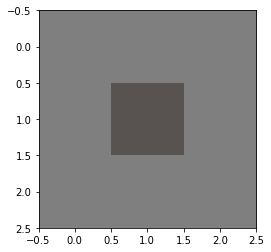

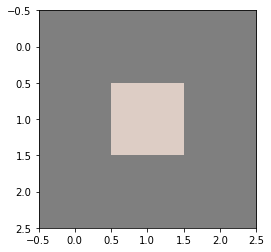

In [21]:
plt.imshow(k)
plt.show()
plt.imshow(kw)
plt.show()

In [19]:
def compute_loss(weights, model):
	image_lambda, image_white = generate_images(weights)
	response_white = model.predict(image_white)
	response_lambda = model.predict(image_lambda)
	dist = (response_white - response_lambda)**2
	dist = tf.reduce_sum(dist, axis=[1,2,3])
	return dist

In [35]:
@tf.function
def gradient_ascent_step(weights, model, learning_rate):
	with tf.GradientTape() as tape:
		# tape.watch(weights)
		loss = compute_loss(weights, model)

	grads = tape.gradient(loss, weights)
	grads = tf.math.l2_normalize(grads)
	weights += learning_rate * grads

	return loss

In [11]:
def modify_input(lambda_atd, white_atd, weights):
    a = lambda_atd[1] + weights[0] - weights[1]
    b = lambda_atd[2] + weights[2] - weights[3]
    c = white_atd[1] + weights[4] - weights[5]
    d = white_atd[2] + weights[6] - weights[7]
    return tf.concat([lambda_atd[0], a, b], axis=-1), tf.concat([white_atd[0], c, d], axis=-1)

## Training loop

The idea is to define a pair of images and move the weights in the direction that minimizes the distance in the transformed domain:

In [16]:
EPOCHS = 10000
norm_grads = False
learning_rate = 3e-4
losses = []
gradients = []

## Initialize weights
weights = initialize_weights_2()

atd_i, atd_w_i = generate_images_atd(lambdas = np.linspace(380,770,300),
                                     central_lambda=450, width = 1, 
                                     max_radiance=1.5e-3, background=0.2e-3)

for epoch in tqdm(range(EPOCHS)):
    ## Pass them through the model and calculate loss
    with tf.GradientTape() as tape:
        ## Add the weights
        atd_mod, atd_w_mod = modify_input(atd_i, atd_w_i, weights)
        ## Transform from ATD -> RGB
        rgb_mod = atd2nrgb_tf(atd_mod[:,None], gamma)
        rgb_w_mod = atd2nrgb_tf(atd_w_mod[:,None], gamma)
        ## Build the images
        image_lambda_mod = tf.ones(shape=(1,384,512,3), dtype=tf.float32)*tf.transpose(rgb_mod, perm=[1,0])
        image_white_mod = tf.ones(shape=(1,384,512,3), dtype=tf.float32)*tf.transpose(rgb_w_mod, perm=[1,0])
        ## Pass them through the model and calculate loss
        response_lambda, response_white = model(image_lambda_mod), model(image_white_mod)
        loss = (response_white - response_lambda)**2
        loss = tf.reduce_sum(loss, axis=[1,2,3])

    ## Obtain gradients and update weights
    grads = tape.gradient(loss, weights)

    # if epoch%50==0:
    #         print(f'Epoch {epoch+1} -> Loss: {loss.numpy()} | Grads: {grads.numpy()}')
    losses.append(loss.numpy().mean())
    gradients.append(grads.numpy().mean())

    ## Normalize the gradients
    if norm_grads:
        grads = tf.math.l2_normalize(grads)
    weights.assign_add(-learning_rate*grads)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
weights

<tf.Variable 'Variable:0' shape=(8,) dtype=float32, numpy=
array([ 0.86736846, -0.86736846,  0.16549611, -0.16549611,  0.10432528,
       -0.10432528,  3.9356756 , -3.9356756 ], dtype=float32)>

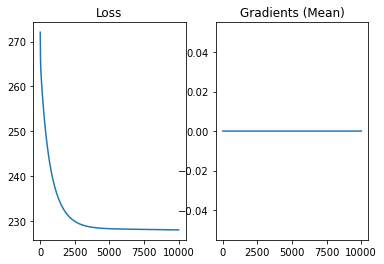

In [17]:
fig, ax = plt.subplots(1,2)

ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(gradients)
ax[1].set_title('Gradients (Mean)')

plt.show()

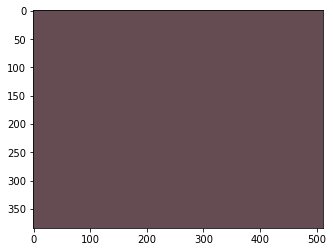

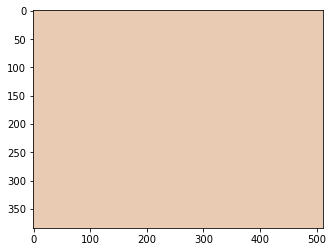

In [18]:
plt.imshow(image_lambda_mod.numpy().squeeze())
plt.show()
plt.imshow(image_white_mod.numpy().squeeze())
plt.show()

## Easy example to figure things out first

In [93]:
EPOCHS = 1000
norm_grads = False
learning_rate = 3e-4

## Initialize weights
weights = tf.Variable([0,0,0], trainable=True, dtype=tf.float32)

## Build images
image_lambda = np.ones(shape=(1,384,512,3))*np.array([0,0,1])[None,:]
image_white = np.ones(shape=(1,384,512,3))
image_lambda = tf.convert_to_tensor(image_lambda, dtype=tf.float32)
image_white = tf.convert_to_tensor(image_white, dtype=tf.float32)
# image_white_mod = image_white
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        ## Add the weights
        image_white_mod = image_white + weights
        # image_white_mod = tf.clip_by_value(image_white_mod, 0, 1)
        ## Pass them through the model and calculate loss
        response_lambda, response_white = model(image_lambda), model(image_white_mod)
        loss = (response_white - response_lambda)**2
        loss = tf.reduce_sum(loss, axis=[1,2,3])
    ## Obtain gradients and update weights
    grads = tape.gradient(loss, weights)

    if epoch%20==0:
        print(f'Epoch {epoch+1} -> Loss: {loss.numpy()} | Grads: {grads.numpy()}')

    ## Normalize the gradients
    if norm_grads:
        grads = tf.math.l2_normalize(grads)
    weights.assign_add(-learning_rate*grads)

Epoch 1 -> Loss: [3130.6042] | Grads: [ 1772.633   1184.6328 -3215.1475]
Epoch 21 -> Loss: [14.902851] | Grads: [45.005096  -0.4005127 13.835519 ]
Epoch 41 -> Loss: [8.414326] | Grads: [18.235994 -0.554718 10.854494]
Epoch 61 -> Loss: [6.821515] | Grads: [ 8.23419   -0.5699196  8.819418 ]
Epoch 81 -> Loss: [6.2152085] | Grads: [ 3.43324    -0.56066895  7.6212997 ]
Epoch 101 -> Loss: [5.8682985] | Grads: [ 0.7937412 -0.5584526  6.967372 ]
Epoch 121 -> Loss: [5.5877447] | Grads: [-0.7720051  -0.57845306  6.673232  ]
Epoch 141 -> Loss: [5.3112364] | Grads: [-1.7504172  -0.60845566  6.6231203 ]
Epoch 161 -> Loss: [5.015762] | Grads: [-2.3899884  -0.65540314  6.741265  ]
Epoch 181 -> Loss: [4.6901913] | Grads: [-2.8329675 -0.7189789  6.9761057]
Epoch 201 -> Loss: [4.328104] | Grads: [-3.1606283  -0.79624176  7.293157  ]
Epoch 221 -> Loss: [3.9240086] | Grads: [-3.4199693  -0.88468933  7.664187  ]
Epoch 241 -> Loss: [3.4736733] | Grads: [-3.6292386 -0.9852867  8.061151 ]
Epoch 261 -> Loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


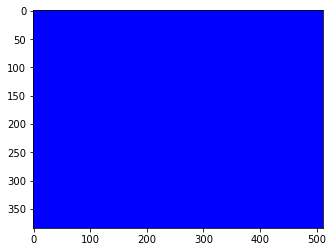

In [94]:
plt.imshow(image_white_mod.numpy().squeeze())
plt.show()

In [71]:
weights, loss, grads

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.53178996,  0.35538986, -0.9645443 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([9355.303], dtype=float32)>,
 None)